## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd

In [3]:
# место для кода
data = pd.read_csv('data.csv')
data.head()

,L1_S24_F1844,L1_S24_F1846,Response
0,-0.123,0.111,0
1,-0.269,0.175,0
2,-0.058,0.141,0
3,0.136,-0.145,0
4,0.045,-0.094,0


## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


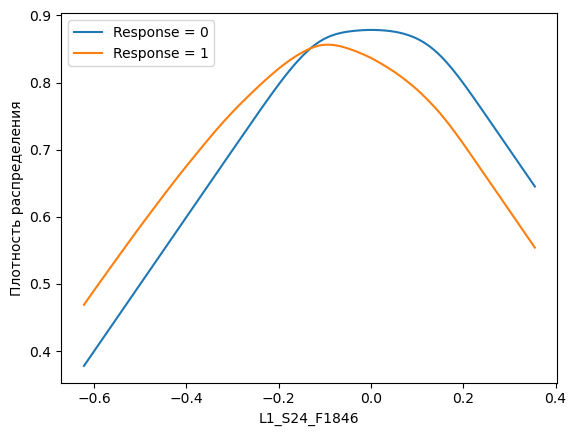

In [5]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# Чтение данных из файла
data = pd.read_csv('data.csv')

# Фильтрация данных по значению Response
response_0 = data[data['Response'] == 0]['L1_S24_F1846']
response_1 = data[data['Response'] == 1]['L1_S24_F1846']

# Подготовка данных для оценки плотности распределения
response_0_values = response_0.values.reshape(-1, 1)
response_1_values = response_1.values.reshape(-1, 1)

# Создание и обучение оценщиков плотности распределения с линейным ядром
kde_0 = KernelDensity(kernel='linear').fit(response_0_values)
kde_1 = KernelDensity(kernel='linear').fit(response_1_values)

# Генерация значений для построения графика
x_plot = np.linspace(min(data['L1_S24_F1846']), max(data['L1_S24_F1846']), 1000).reshape(-1, 1)
dens_0 = np.exp(kde_0.score_samples(x_plot))
dens_1 = np.exp(kde_1.score_samples(x_plot))

# Построение графика
plt.plot(x_plot, dens_0, label='Response = 0')
plt.plot(x_plot, dens_1, label='Response = 1')
plt.xlabel('L1_S24_F1846')
plt.ylabel('Плотность распределения')
plt.legend()
plt.show()

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

In [ ]:
# место для кода

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [ ]:
# На основе графика плотности распределения,
# построенного в предыдущем ответе, можно заметить,
# что плотности распределения признака L1_S24_F1846 для классов Response = 0 и Response = 1
# имеют значительное перекрытие в области значений признака от примерно -0.2 до 0.2. 
# Поэтому можно сделать вывод, что выборка не является хорошо разделимой по этому признаку.

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [6]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KernelDensity
import numpy as np

# Функция для подсчета логарифма правдоподобия
def compute_log_likelihood(bandwidth, X_train, X_test):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_train)
    log_prob = kde.score_samples(X_test)
    log_prob[np.isinf(log_prob)] = -100
    log_likelihood = log_prob.sum()
    return log_likelihood

# Разделение данных на обучающую и проверочную выборки
dataTrain = data[data['Response'] == 0]  # Обучающая выборка для Response = 0
dataTest = data[data['Response'] == 1]   # Проверочная выборка для Response = 1

# Подбор значения bandwidth для класса Response = 0
X_train_0 = dataTrain['L1_S24_F1846'].values.reshape(-1, 1)
X_test_0 = dataTest['L1_S24_F1846'].values.reshape(-1, 1)
bandwidths_0 = np.linspace(0.01, 1.0, 20)  # Задаем диапазон значений bandwidth
log_likelihoods_0 = []
for bandwidth in bandwidths_0:
    log_likelihood = compute_log_likelihood(bandwidth, X_train_0, X_test_0)
    log_likelihoods_0.append(log_likelihood)
best_bandwidth_0 = bandwidths_0[np.argmax(log_likelihoods_0)]
print("Best bandwidth for Response = 0:", best_bandwidth_0)

# Подбор значения bandwidth для класса Response = 1
X_train_1 = dataTrain['L1_S24_F1846'].values.reshape(-1, 1)
X_test_1 = dataTest['L1_S24_F1846'].values.reshape(-1, 1)
bandwidths_1 = np.linspace(0.01, 1.0, 20)  # Задаем диапазон значений bandwidth
log_likelihoods_1 = []
for bandwidth in bandwidths_1:
    log_likelihood = compute_log_likelihood(bandwidth, X_train_1, X_test_1)
    log_likelihoods_1.append(log_likelihood)
best_bandwidth_1 = bandwidths_1[np.argmax(log_likelihoods_1)]
print("Best bandwidth for Response = 1:", best_bandwidth_1)

Best bandwidth for Response = 0: 0.16631578947368422
Best bandwidth for Response = 1: 0.16631578947368422


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [9]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

NameError: name 'kde0' is not defined

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [17]:
# разбиваем выборку на тренировочную и тестовую
#dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
#dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)
from sklearn.model_selection import train_test_split

X = data[['L1_S24_F1846']]
y = data['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# инициализируем классы
kde0.set_params(bandwidth=0.35)
kde1.set_params(bandwidth=0.09)
kde0 = KernelDensity(kernel='gaussian')
kde1 = KernelDensity(kernel='gaussian')
kde0.fit(X_train.loc[y_train==0])
kde1.fit(X_train.loc[y_train==1])
# обучаем классы с наилучшими значениями bandwidth

#kde0.fit(dataTrain.loc[dataTrain['Response']==0, 'L1_S24_F1846'].values.reshape(-1, 1))

#kde1.fit(dataTrain.loc[dataTrain['Response']==1, 'L1_S24_F1846'].values.reshape(-1, 1))

# вычисляем p(x|0) и p(x|1) для тестовой выборки
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

# находим p(0|x) и p(1|x)
p0givenX = predictionProbXafter0 / (predictionProbXafter0 + predictionProbXafter1)
p1givenX = predictionProbXafter1 / (predictionProbXafter0 + predictionProbXafter1)

# сортируем объекты по возрастанию p(1|x)
ind = np.argsort(p1givenX)

# выводим вероятности для последних 10 объектов
print(p1givenX[ind[-10:]])


E:\Programms\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


[0.51205737 0.51241139 0.51243865 0.51243865 0.51246592 0.51249319
 0.51252047 0.51265692 0.51265692 0.51276616]


E:\Programms\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
